In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

look_backs = [60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.25, 0.30),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.30, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.20, 0.25),
    "CONV_K":        trial.suggest_int("CONV_K",  2, 9),
    "CONV_DILATION": trial.suggest_int("CONV_DILATION",   1, 3),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    7e-5, 1e-4,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-5, 1e-3,   log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.5, 1),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors...')
    X, y_sig, y_ret, raw_close, end_times = models_core.build_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models_core.chronological_split(
        X, y_sig, y_ret, raw_close,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
        # train split:   
        X_tr,       y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,      y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,       y_sig_te,     y_ret_te,   end_times_te,    raw_close_te, 
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = dual_lstm.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT'],
        conv_k         = hp['CONV_K'],
        conv_dilation  = hp['CONV_DILATION']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = dual_lstm.lstm_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_close_te
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


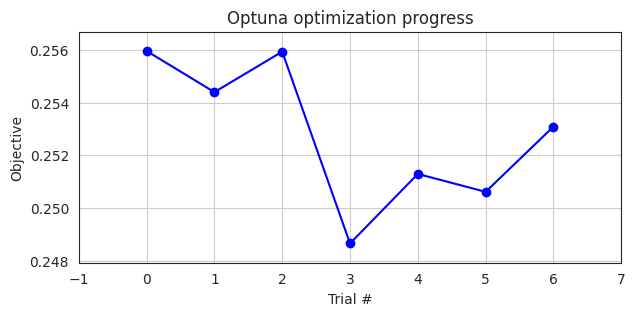

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-25 17:17:02,990] A new study created in RDB with name: no-name-f21071c3-b75e-4baa-b8d7-5cab185fcc5b



▶ Trial 0 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.29190134343475965, 'DROPOUT_LONG': 0.30502970061448165, 'ATT_DROPOUT': 0.24095527318038654, 'CONV_K': 9, 'CONV_DILATION': 3, 'INITIAL_LR': 9.545613030351589e-05, 'ETA_MIN': 1.2809154309136935e-06, 'WEIGHT_DECAY': 0.0001811061017724913, 'CLIPNORM': 0.9188685778734582}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


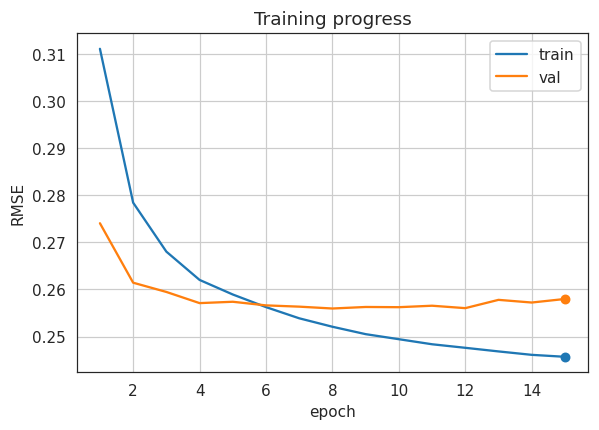

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3111 MAE=0.2379 R2=-0.1469 | Acc=0.7007 Prec=0.3761 Rec=0.1246 F1=0.1871 AUROC=0.5895
VALID→ RMSE=0.2741 MAE=0.1917 R2=0.0882 | Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6440


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2784 MAE=0.2153 R2=0.0812 | Acc=0.7083 Prec=0.3853 Rec=0.0917 F1=0.1481 AUROC=0.5779
VALID→ RMSE=0.2614 MAE=0.1871 R2=0.1703 | Acc=0.7135 Prec=0.9231 Rec=0.0031 F1=0.0061 AUROC=0.7067


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2680 MAE=0.2049 R2=0.1485 | Acc=0.7281 Prec=0.5397 Rec=0.1173 F1=0.1928 AUROC=0.6397
VALID→ RMSE=0.2595 MAE=0.1856 R2=0.1827 | Acc=0.7315 Prec=0.7583 Rec=0.0958 F1=0.1702 AUROC=0.7324


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2620 MAE=0.2000 R2=0.1862 | Acc=0.7431 Prec=0.6031 Rec=0.2090 F1=0.3105 AUROC=0.6953
VALID→ RMSE=0.2571 MAE=0.1866 R2=0.1975 | Acc=0.7452 Prec=0.6829 Rec=0.2113 F1=0.3227 AUROC=0.7373


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2589 MAE=0.1982 R2=0.2053 | Acc=0.7507 Prec=0.6082 Rec=0.2774 F1=0.3810 AUROC=0.7197
VALID→ RMSE=0.2574 MAE=0.1864 R2=0.1957 | Acc=0.7472 Prec=0.6681 Rec=0.2386 F1=0.3516 AUROC=0.7367


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2563 MAE=0.1957 R2=0.2217 | Acc=0.7547 Prec=0.6181 Rec=0.2966 F1=0.4009 AUROC=0.7317
VALID→ RMSE=0.2566 MAE=0.1867 R2=0.2005 | Acc=0.7472 Prec=0.6620 Rec=0.2452 F1=0.3578 AUROC=0.7370


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2539 MAE=0.1933 R2=0.2360 | Acc=0.7576 Prec=0.6240 Rec=0.3118 F1=0.4158 AUROC=0.7402
VALID→ RMSE=0.2564 MAE=0.1874 R2=0.2022 | Acc=0.7470 Prec=0.6463 Rec=0.2640 F1=0.3748 AUROC=0.7361


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2521 MAE=0.1916 R2=0.2468 | Acc=0.7599 Prec=0.6285 Rec=0.3232 F1=0.4268 AUROC=0.7472
VALID→ RMSE=0.2560 MAE=0.1883 R2=0.2046 | Acc=0.7464 Prec=0.6401 Rec=0.2677 F1=0.3775 AUROC=0.7349


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2505 MAE=0.1903 R2=0.2561 | Acc=0.7616 Prec=0.6313 Rec=0.3324 F1=0.4355 AUROC=0.7529
VALID→ RMSE=0.2563 MAE=0.1884 R2=0.2026 | Acc=0.7456 Prec=0.6380 Rec=0.2649 F1=0.3744 AUROC=0.7347


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2495 MAE=0.1894 R2=0.2625 | Acc=0.7630 Prec=0.6331 Rec=0.3405 F1=0.4429 AUROC=0.7569
VALID→ RMSE=0.2562 MAE=0.1889 R2=0.2029 | Acc=0.7451 Prec=0.6350 Rec=0.2656 F1=0.3746 AUROC=0.7344


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2484 MAE=0.1884 R2=0.2688 | Acc=0.7639 Prec=0.6346 Rec=0.3455 F1=0.4474 AUROC=0.7606
VALID→ RMSE=0.2566 MAE=0.1893 R2=0.2010 | Acc=0.7445 Prec=0.6317 Rec=0.2654 F1=0.3738 AUROC=0.7344


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2476 MAE=0.1875 R2=0.2732 | Acc=0.7651 Prec=0.6364 Rec=0.3516 F1=0.4529 AUROC=0.7637
VALID→ RMSE=0.2560 MAE=0.1901 R2=0.2042 | Acc=0.7448 Prec=0.6256 Rec=0.2785 F1=0.3854 AUROC=0.7347


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2469 MAE=0.1872 R2=0.2777 | Acc=0.7656 Prec=0.6352 Rec=0.3588 F1=0.4586 AUROC=0.7664
VALID→ RMSE=0.2578 MAE=0.1900 R2=0.1932 | Acc=0.7431 Prec=0.6257 Rec=0.2633 F1=0.3707 AUROC=0.7325


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2461 MAE=0.1862 R2=0.2820 | Acc=0.7669 Prec=0.6403 Rec=0.3590 F1=0.4600 AUROC=0.7685
VALID→ RMSE=0.2572 MAE=0.1908 R2=0.1967 | Acc=0.7434 Prec=0.6181 Rec=0.2799 F1=0.3853 AUROC=0.7329


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2457 MAE=0.1859 R2=0.2844 | Acc=0.7672 Prec=0.6383 Rec=0.3658 F1=0.4651 AUROC=0.7703
VALID→ RMSE=0.2580 MAE=0.1912 R2=0.1920 | Acc=0.7425 Prec=0.6153 Rec=0.2766 F1=0.3817 AUROC=0.7311
Early stopping at epoch 15
✅ Final best model (_fin) saved: AAPL_0.25596_fin.pth
Delete variables to free memory...


[I 2025-09-25 17:31:32,985] Trial 0 finished with value: 0.25596490502357483 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.29190134343475965, 'DROPOUT_LONG': 0.30502970061448165, 'ATT_DROPOUT': 0.24095527318038654, 'CONV_K': 9, 'CONV_DILATION': 3, 'INITIAL_LR': 9.545613030351589e-05, 'ETA_MIN': 1.2809154309136935e-06, 'WEIGHT_DECAY': 0.0001811061017724913, 'CLIPNORM': 0.9188685778734582}. Best is trial 0 with value: 0.25596490502357483.



▶ Trial 1 starting with:
{'look_back': 75, 'DROPOUT_SHORT': 0.2849777459785659, 'DROPOUT_LONG': 0.3462474722600415, 'ATT_DROPOUT': 0.21345000096723488, 'CONV_K': 4, 'CONV_DILATION': 2, 'INITIAL_LR': 9.847165786284599e-05, 'ETA_MIN': 3.4695507280575103e-06, 'WEIGHT_DECAY': 0.0004947150082750987, 'CLIPNORM': 0.7806231799965646}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


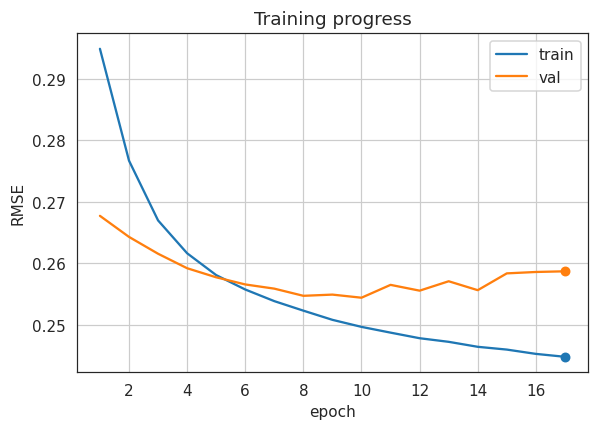

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2949 MAE=0.2262 R2=-0.0325 | Acc=0.6999 Prec=0.3510 Rec=0.1099 F1=0.1673 AUROC=0.5723
VALID→ RMSE=0.2677 MAE=0.1871 R2=0.1259 | Acc=0.7158 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6861


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2767 MAE=0.2103 R2=0.0909 | Acc=0.7146 Prec=0.4222 Rec=0.1072 F1=0.1710 AUROC=0.5934
VALID→ RMSE=0.2643 MAE=0.1860 R2=0.1481 | Acc=0.7274 Prec=0.8426 Rec=0.0502 F1=0.0948 AUROC=0.7201


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2670 MAE=0.2018 R2=0.1537 | Acc=0.7384 Prec=0.5875 Rec=0.1586 F1=0.2498 AUROC=0.6676
VALID→ RMSE=0.2616 MAE=0.1866 R2=0.1657 | Acc=0.7469 Prec=0.6802 Rec=0.2065 F1=0.3168 AUROC=0.7246


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2616 MAE=0.1982 R2=0.1872 | Acc=0.7503 Prec=0.6082 Rec=0.2544 F1=0.3588 AUROC=0.7091
VALID→ RMSE=0.2592 MAE=0.1866 R2=0.1807 | Acc=0.7506 Prec=0.6399 Rec=0.2798 F1=0.3893 AUROC=0.7250


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2581 MAE=0.1962 R2=0.2092 | Acc=0.7548 Prec=0.6159 Rec=0.2840 F1=0.3888 AUROC=0.7249
VALID→ RMSE=0.2577 MAE=0.1865 R2=0.1900 | Acc=0.7514 Prec=0.6374 Rec=0.2906 F1=0.3992 AUROC=0.7265


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2557 MAE=0.1945 R2=0.2235 | Acc=0.7575 Prec=0.6220 Rec=0.2973 F1=0.4023 AUROC=0.7337
VALID→ RMSE=0.2566 MAE=0.1860 R2=0.1973 | Acc=0.7525 Prec=0.6405 Rec=0.2939 F1=0.4029 AUROC=0.7291


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2538 MAE=0.1931 R2=0.2349 | Acc=0.7598 Prec=0.6276 Rec=0.3075 F1=0.4128 AUROC=0.7405
VALID→ RMSE=0.2559 MAE=0.1857 R2=0.2015 | Acc=0.7531 Prec=0.6433 Rec=0.2946 F1=0.4041 AUROC=0.7313


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2523 MAE=0.1917 R2=0.2442 | Acc=0.7615 Prec=0.6307 Rec=0.3164 F1=0.4214 AUROC=0.7459
VALID→ RMSE=0.2547 MAE=0.1863 R2=0.2088 | Acc=0.7535 Prec=0.6378 Rec=0.3068 F1=0.4143 AUROC=0.7337


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2508 MAE=0.1903 R2=0.2531 | Acc=0.7629 Prec=0.6341 Rec=0.3227 F1=0.4278 AUROC=0.7506
VALID→ RMSE=0.2549 MAE=0.1856 R2=0.2076 | Acc=0.7539 Prec=0.6525 Rec=0.2867 F1=0.3984 AUROC=0.7353


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2497 MAE=0.1896 R2=0.2599 | Acc=0.7643 Prec=0.6368 Rec=0.3289 F1=0.4338 AUROC=0.7549
VALID→ RMSE=0.2544 MAE=0.1873 R2=0.2107 | Acc=0.7534 Prec=0.6442 Rec=0.2951 F1=0.4048 AUROC=0.7354


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2487 MAE=0.1887 R2=0.2655 | Acc=0.7654 Prec=0.6383 Rec=0.3357 F1=0.4400 AUROC=0.7578
VALID→ RMSE=0.2565 MAE=0.1850 R2=0.1977 | Acc=0.7525 Prec=0.6633 Rec=0.2622 F1=0.3758 AUROC=0.7355


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2478 MAE=0.1877 R2=0.2708 | Acc=0.7667 Prec=0.6415 Rec=0.3402 F1=0.4447 AUROC=0.7605
VALID→ RMSE=0.2555 MAE=0.1876 R2=0.2036 | Acc=0.7519 Prec=0.6514 Rec=0.2728 F1=0.3846 AUROC=0.7345


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2472 MAE=0.1877 R2=0.2743 | Acc=0.7671 Prec=0.6401 Rec=0.3461 F1=0.4492 AUROC=0.7629
VALID→ RMSE=0.2571 MAE=0.1866 R2=0.1940 | Acc=0.7508 Prec=0.6580 Rec=0.2559 F1=0.3684 AUROC=0.7337


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2464 MAE=0.1864 R2=0.2790 | Acc=0.7684 Prec=0.6442 Rec=0.3492 F1=0.4529 AUROC=0.7654
VALID→ RMSE=0.2556 MAE=0.1878 R2=0.2031 | Acc=0.7512 Prec=0.6473 Rec=0.2732 F1=0.3842 AUROC=0.7352


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2460 MAE=0.1864 R2=0.2817 | Acc=0.7688 Prec=0.6432 Rec=0.3548 F1=0.4573 AUROC=0.7670
VALID→ RMSE=0.2584 MAE=0.1871 R2=0.1859 | Acc=0.7490 Prec=0.6561 Rec=0.2453 F1=0.3571 AUROC=0.7319


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2453 MAE=0.1856 R2=0.2857 | Acc=0.7696 Prec=0.6447 Rec=0.3583 F1=0.4606 AUROC=0.7688
VALID→ RMSE=0.2586 MAE=0.1874 R2=0.1845 | Acc=0.7486 Prec=0.6534 Rec=0.2452 F1=0.3566 AUROC=0.7319


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2448 MAE=0.1852 R2=0.2885 | Acc=0.7703 Prec=0.6454 Rec=0.3622 F1=0.4640 AUROC=0.7709
VALID→ RMSE=0.2587 MAE=0.1882 R2=0.1838 | Acc=0.7482 Prec=0.6475 Rec=0.2502 F1=0.3609 AUROC=0.7309
Early stopping at epoch 17
✅ Final best model (_fin) saved: AAPL_0.25440_fin.pth
Delete variables to free memory...


[I 2025-09-25 17:48:48,363] Trial 1 finished with value: 0.2544015645980835 and parameters: {'look_back': 75, 'DROPOUT_SHORT': 0.2849777459785659, 'DROPOUT_LONG': 0.3462474722600415, 'ATT_DROPOUT': 0.21345000096723488, 'CONV_K': 4, 'CONV_DILATION': 2, 'INITIAL_LR': 9.847165786284599e-05, 'ETA_MIN': 3.4695507280575103e-06, 'WEIGHT_DECAY': 0.0004947150082750987, 'CLIPNORM': 0.7806231799965646}. Best is trial 1 with value: 0.2544015645980835.



▶ Trial 2 starting with:
{'look_back': 75, 'DROPOUT_SHORT': 0.271487019000913, 'DROPOUT_LONG': 0.3261359326698599, 'ATT_DROPOUT': 0.2027370855283443, 'CONV_K': 5, 'CONV_DILATION': 3, 'INITIAL_LR': 8.046381529948793e-05, 'ETA_MIN': 6.867932203859808e-06, 'WEIGHT_DECAY': 0.00011481954200196901, 'CLIPNORM': 0.7924964546552188}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


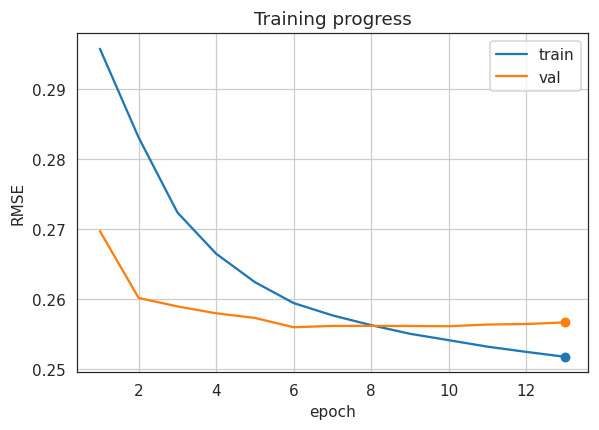

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2957 MAE=0.2265 R2=-0.0384 | Acc=0.7010 Prec=0.3426 Rec=0.0972 F1=0.1514 AUROC=0.5749
VALID→ RMSE=0.2697 MAE=0.1872 R2=0.1131 | Acc=0.7158 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6451


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2830 MAE=0.2176 R2=0.0488 | Acc=0.7066 Prec=0.3663 Rec=0.0941 F1=0.1498 AUROC=0.5735
VALID→ RMSE=0.2601 MAE=0.1852 R2=0.1748 | Acc=0.7158 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7108


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2723 MAE=0.2084 R2=0.1194 | Acc=0.7246 Prec=0.4934 Rec=0.1175 F1=0.1898 AUROC=0.6368
VALID→ RMSE=0.2589 MAE=0.1839 R2=0.1824 | Acc=0.7249 Prec=0.7751 Rec=0.0447 F1=0.0846 AUROC=0.7302


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2664 MAE=0.2037 R2=0.1571 | Acc=0.7366 Prec=0.5548 Rec=0.2045 F1=0.2989 AUROC=0.6812
VALID→ RMSE=0.2579 MAE=0.1835 R2=0.1886 | Acc=0.7424 Prec=0.7255 Rec=0.1506 F1=0.2495 AUROC=0.7354


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2624 MAE=0.2006 R2=0.1826 | Acc=0.7454 Prec=0.5827 Rec=0.2559 F1=0.3557 AUROC=0.7045
VALID→ RMSE=0.2573 MAE=0.1834 R2=0.1928 | Acc=0.7495 Prec=0.6884 Rec=0.2166 F1=0.3295 AUROC=0.7367


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2594 MAE=0.1979 R2=0.2011 | Acc=0.7507 Prec=0.5982 Rec=0.2795 F1=0.3810 AUROC=0.7182
VALID→ RMSE=0.2559 MAE=0.1845 R2=0.2011 | Acc=0.7517 Prec=0.6704 Rec=0.2483 F1=0.3623 AUROC=0.7366


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2576 MAE=0.1968 R2=0.2119 | Acc=0.7537 Prec=0.6070 Rec=0.2922 F1=0.3945 AUROC=0.7267
VALID→ RMSE=0.2561 MAE=0.1848 R2=0.2000 | Acc=0.7521 Prec=0.6649 Rec=0.2569 F1=0.3707 AUROC=0.7363


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2562 MAE=0.1957 R2=0.2204 | Acc=0.7555 Prec=0.6095 Rec=0.3041 F1=0.4057 AUROC=0.7323
VALID→ RMSE=0.2561 MAE=0.1854 R2=0.1999 | Acc=0.7520 Prec=0.6618 Rec=0.2603 F1=0.3736 AUROC=0.7355


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2550 MAE=0.1946 R2=0.2279 | Acc=0.7575 Prec=0.6153 Rec=0.3107 F1=0.4129 AUROC=0.7371
VALID→ RMSE=0.2561 MAE=0.1860 R2=0.2001 | Acc=0.7516 Prec=0.6565 Rec=0.2640 F1=0.3766 AUROC=0.7346


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2541 MAE=0.1940 R2=0.2334 | Acc=0.7586 Prec=0.6174 Rec=0.3176 F1=0.4195 AUROC=0.7401
VALID→ RMSE=0.2561 MAE=0.1868 R2=0.2002 | Acc=0.7517 Prec=0.6524 Rec=0.2703 F1=0.3822 AUROC=0.7338


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2532 MAE=0.1934 R2=0.2390 | Acc=0.7595 Prec=0.6184 Rec=0.3232 F1=0.4246 AUROC=0.7436
VALID→ RMSE=0.2563 MAE=0.1871 R2=0.1987 | Acc=0.7513 Prec=0.6498 Rec=0.2704 F1=0.3819 AUROC=0.7332


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2524 MAE=0.1928 R2=0.2435 | Acc=0.7607 Prec=0.6210 Rec=0.3289 F1=0.4300 AUROC=0.7465
VALID→ RMSE=0.2564 MAE=0.1880 R2=0.1983 | Acc=0.7508 Prec=0.6444 Rec=0.2749 F1=0.3854 AUROC=0.7324


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2517 MAE=0.1923 R2=0.2477 | Acc=0.7614 Prec=0.6221 Rec=0.3331 F1=0.4338 AUROC=0.7490
VALID→ RMSE=0.2566 MAE=0.1885 R2=0.1968 | Acc=0.7504 Prec=0.6403 Rec=0.2774 F1=0.3871 AUROC=0.7318
Early stopping at epoch 13
✅ Final best model (_fin) saved: AAPL_0.25594_fin.pth
Delete variables to free memory...


[I 2025-09-25 18:02:01,462] Trial 2 finished with value: 0.25593918561935425 and parameters: {'look_back': 75, 'DROPOUT_SHORT': 0.271487019000913, 'DROPOUT_LONG': 0.3261359326698599, 'ATT_DROPOUT': 0.2027370855283443, 'CONV_K': 5, 'CONV_DILATION': 3, 'INITIAL_LR': 8.046381529948793e-05, 'ETA_MIN': 6.867932203859808e-06, 'WEIGHT_DECAY': 0.00011481954200196901, 'CLIPNORM': 0.7924964546552188}. Best is trial 1 with value: 0.2544015645980835.



▶ Trial 3 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.2552145008621676, 'DROPOUT_LONG': 0.33154597016373705, 'ATT_DROPOUT': 0.20456227552679312, 'CONV_K': 7, 'CONV_DILATION': 3, 'INITIAL_LR': 8.664448533701658e-05, 'ETA_MIN': 1.0535525199631753e-06, 'WEIGHT_DECAY': 0.0003692206365754885, 'CLIPNORM': 0.615206989053804}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


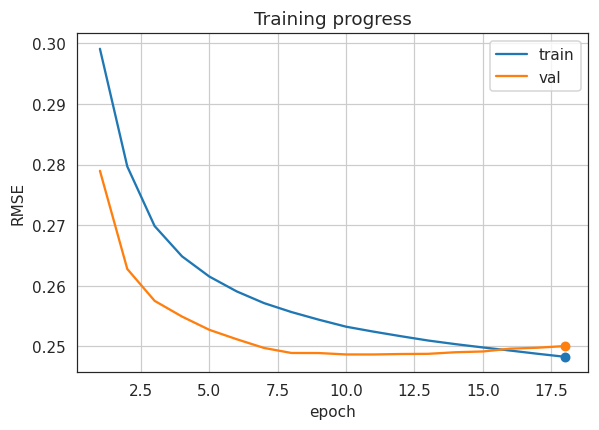

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2991 MAE=0.2289 R2=-0.0650 | Acc=0.7022 Prec=0.3241 Rec=0.0849 F1=0.1346 AUROC=0.5576
VALID→ RMSE=0.2790 MAE=0.1923 R2=0.0421 | Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6480


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2797 MAE=0.2144 R2=0.0689 | Acc=0.7141 Prec=0.3925 Rec=0.0888 F1=0.1448 AUROC=0.5748
VALID→ RMSE=0.2628 MAE=0.1851 R2=0.1502 | Acc=0.7226 Prec=0.9176 Rec=0.0117 F1=0.0230 AUROC=0.7249


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2699 MAE=0.2053 R2=0.1332 | Acc=0.7346 Prec=0.5456 Rec=0.1593 F1=0.2466 AUROC=0.6536
VALID→ RMSE=0.2575 MAE=0.1824 R2=0.1839 | Acc=0.7452 Prec=0.7554 Rec=0.1350 F1=0.2291 AUROC=0.7368


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2649 MAE=0.2020 R2=0.1650 | Acc=0.7445 Prec=0.5722 Rec=0.2499 F1=0.3478 AUROC=0.6942
VALID→ RMSE=0.2549 MAE=0.1816 R2=0.2002 | Acc=0.7541 Prec=0.7016 Rec=0.2140 F1=0.3280 AUROC=0.7409


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2615 MAE=0.1994 R2=0.1859 | Acc=0.7499 Prec=0.5876 Rec=0.2776 F1=0.3770 AUROC=0.7101
VALID→ RMSE=0.2527 MAE=0.1813 R2=0.2139 | Acc=0.7571 Prec=0.6887 Rec=0.2442 F1=0.3606 AUROC=0.7439


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2591 MAE=0.1975 R2=0.2011 | Acc=0.7527 Prec=0.5946 Rec=0.2916 F1=0.3913 AUROC=0.7187
VALID→ RMSE=0.2512 MAE=0.1813 R2=0.2236 | Acc=0.7583 Prec=0.6856 Rec=0.2550 F1=0.3717 AUROC=0.7464


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2571 MAE=0.1956 R2=0.2130 | Acc=0.7553 Prec=0.6037 Rec=0.2981 F1=0.3992 AUROC=0.7257
VALID→ RMSE=0.2497 MAE=0.1818 R2=0.2324 | Acc=0.7592 Prec=0.6825 Rec=0.2642 F1=0.3810 AUROC=0.7485


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2557 MAE=0.1944 R2=0.2220 | Acc=0.7573 Prec=0.6095 Rec=0.3061 F1=0.4075 AUROC=0.7311
VALID→ RMSE=0.2489 MAE=0.1824 R2=0.2375 | Acc=0.7600 Prec=0.6830 Rec=0.2686 F1=0.3856 AUROC=0.7503


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2544 MAE=0.1934 R2=0.2296 | Acc=0.7585 Prec=0.6121 Rec=0.3119 F1=0.4133 AUROC=0.7359
VALID→ RMSE=0.2489 MAE=0.1824 R2=0.2376 | Acc=0.7602 Prec=0.6852 Rec=0.2681 F1=0.3854 AUROC=0.7513


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2532 MAE=0.1924 R2=0.2366 | Acc=0.7600 Prec=0.6162 Rec=0.3172 F1=0.4188 AUROC=0.7403
VALID→ RMSE=0.2487 MAE=0.1829 R2=0.2390 | Acc=0.7603 Prec=0.6848 Rec=0.2693 F1=0.3866 AUROC=0.7518


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2524 MAE=0.1917 R2=0.2416 | Acc=0.7612 Prec=0.6192 Rec=0.3228 F1=0.4244 AUROC=0.7437
VALID→ RMSE=0.2487 MAE=0.1831 R2=0.2390 | Acc=0.7605 Prec=0.6828 Rec=0.2728 F1=0.3899 AUROC=0.7522


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2517 MAE=0.1910 R2=0.2461 | Acc=0.7623 Prec=0.6219 Rec=0.3267 F1=0.4283 AUROC=0.7463
VALID→ RMSE=0.2487 MAE=0.1831 R2=0.2386 | Acc=0.7606 Prec=0.6833 Rec=0.2729 F1=0.3901 AUROC=0.7525


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2510 MAE=0.1905 R2=0.2504 | Acc=0.7632 Prec=0.6251 Rec=0.3289 F1=0.4310 AUROC=0.7485
VALID→ RMSE=0.2488 MAE=0.1837 R2=0.2384 | Acc=0.7603 Prec=0.6806 Rec=0.2735 F1=0.3902 AUROC=0.7520


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2504 MAE=0.1899 R2=0.2539 | Acc=0.7645 Prec=0.6287 Rec=0.3323 F1=0.4348 AUROC=0.7513
VALID→ RMSE=0.2490 MAE=0.1838 R2=0.2368 | Acc=0.7602 Prec=0.6812 Rec=0.2723 F1=0.3891 AUROC=0.7517


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2498 MAE=0.1893 R2=0.2572 | Acc=0.7651 Prec=0.6312 Rec=0.3331 F1=0.4361 AUROC=0.7532
VALID→ RMSE=0.2491 MAE=0.1845 R2=0.2360 | Acc=0.7602 Prec=0.6777 Rec=0.2764 F1=0.3926 AUROC=0.7508


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2493 MAE=0.1890 R2=0.2602 | Acc=0.7658 Prec=0.6316 Rec=0.3380 F1=0.4404 AUROC=0.7551
VALID→ RMSE=0.2496 MAE=0.1844 R2=0.2332 | Acc=0.7599 Prec=0.6790 Rec=0.2724 F1=0.3889 AUROC=0.7499


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2488 MAE=0.1883 R2=0.2634 | Acc=0.7666 Prec=0.6356 Rec=0.3377 F1=0.4411 AUROC=0.7572
VALID→ RMSE=0.2498 MAE=0.1847 R2=0.2322 | Acc=0.7596 Prec=0.6748 Rec=0.2753 F1=0.3911 AUROC=0.7492


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2483 MAE=0.1880 R2=0.2663 | Acc=0.7671 Prec=0.6342 Rec=0.3441 F1=0.4461 AUROC=0.7589
VALID→ RMSE=0.2500 MAE=0.1856 R2=0.2305 | Acc=0.7592 Prec=0.6688 Rec=0.2797 F1=0.3944 AUROC=0.7479
Early stopping at epoch 18
✅ Final best model (_fin) saved: AAPL_0.24865_fin.pth
Delete variables to free memory...


[I 2025-09-25 18:20:13,498] Trial 3 finished with value: 0.24865210056304932 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.2552145008621676, 'DROPOUT_LONG': 0.33154597016373705, 'ATT_DROPOUT': 0.20456227552679312, 'CONV_K': 7, 'CONV_DILATION': 3, 'INITIAL_LR': 8.664448533701658e-05, 'ETA_MIN': 1.0535525199631753e-06, 'WEIGHT_DECAY': 0.0003692206365754885, 'CLIPNORM': 0.615206989053804}. Best is trial 3 with value: 0.24865210056304932.



▶ Trial 4 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.2647145427684293, 'DROPOUT_LONG': 0.335065099779656, 'ATT_DROPOUT': 0.206408550386552, 'CONV_K': 3, 'CONV_DILATION': 2, 'INITIAL_LR': 8.484988914537817e-05, 'ETA_MIN': 1.2094678355042801e-06, 'WEIGHT_DECAY': 4.599527335628611e-05, 'CLIPNORM': 0.9002594571417843}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


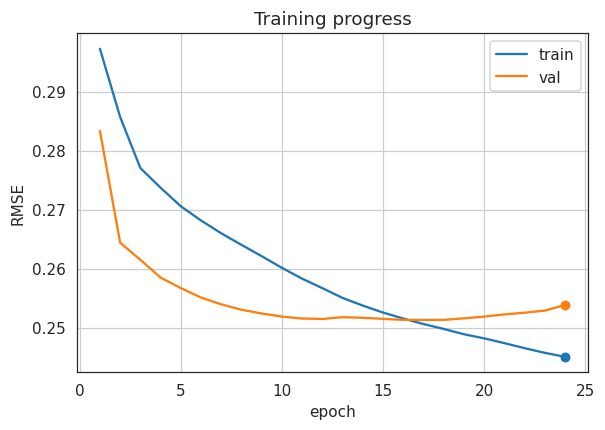

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2972 MAE=0.2285 R2=-0.0472 | Acc=0.6823 Prec=0.3403 Rec=0.1584 F1=0.2162 AUROC=0.5596
VALID→ RMSE=0.2833 MAE=0.1918 R2=0.0255 | Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6430


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2857 MAE=0.2188 R2=0.0327 | Acc=0.7136 Prec=0.3751 Rec=0.0528 F1=0.0925 AUROC=0.5301
VALID→ RMSE=0.2644 MAE=0.1844 R2=0.1515 | Acc=0.7172 Prec=0.9079 Rec=0.0173 F1=0.0340 AUROC=0.7116


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2770 MAE=0.2120 R2=0.0904 | Acc=0.7258 Prec=0.5250 Rec=0.0933 F1=0.1584 AUROC=0.5979
VALID→ RMSE=0.2615 MAE=0.1829 R2=0.1700 | Acc=0.7310 Prec=0.7925 Rec=0.0861 F1=0.1553 AUROC=0.7328


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2737 MAE=0.2098 R2=0.1121 | Acc=0.7341 Prec=0.5670 Rec=0.1647 F1=0.2552 AUROC=0.6382
VALID→ RMSE=0.2585 MAE=0.1826 R2=0.1890 | Acc=0.7406 Prec=0.7553 Rec=0.1438 F1=0.2416 AUROC=0.7396


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2706 MAE=0.2080 R2=0.1324 | Acc=0.7391 Prec=0.5780 Rec=0.2109 F1=0.3090 AUROC=0.6607
VALID→ RMSE=0.2567 MAE=0.1824 R2=0.2001 | Acc=0.7459 Prec=0.7326 Rec=0.1817 F1=0.2912 AUROC=0.7431


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2682 MAE=0.2065 R2=0.1478 | Acc=0.7423 Prec=0.5837 Rec=0.2386 F1=0.3387 AUROC=0.6751
VALID→ RMSE=0.2551 MAE=0.1825 R2=0.2101 | Acc=0.7489 Prec=0.7171 Rec=0.2080 F1=0.3225 AUROC=0.7452


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2660 MAE=0.2049 R2=0.1615 | Acc=0.7452 Prec=0.5917 Rec=0.2547 F1=0.3561 AUROC=0.6874
VALID→ RMSE=0.2539 MAE=0.1825 R2=0.2172 | Acc=0.7505 Prec=0.7071 Rec=0.2244 F1=0.3407 AUROC=0.7466


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2640 MAE=0.2032 R2=0.1738 | Acc=0.7480 Prec=0.6013 Rec=0.2642 F1=0.3671 AUROC=0.6980
VALID→ RMSE=0.2530 MAE=0.1828 R2=0.2228 | Acc=0.7515 Prec=0.6985 Rec=0.2376 F1=0.3546 AUROC=0.7475


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2621 MAE=0.2017 R2=0.1858 | Acc=0.7502 Prec=0.6072 Rec=0.2751 F1=0.3787 AUROC=0.7071
VALID→ RMSE=0.2524 MAE=0.1831 R2=0.2267 | Acc=0.7518 Prec=0.6938 Rec=0.2433 F1=0.3603 AUROC=0.7478


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2601 MAE=0.2000 R2=0.1980 | Acc=0.7523 Prec=0.6124 Rec=0.2849 F1=0.3889 AUROC=0.7152
VALID→ RMSE=0.2519 MAE=0.1836 R2=0.2300 | Acc=0.7522 Prec=0.6890 Rec=0.2505 F1=0.3674 AUROC=0.7476


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2583 MAE=0.1984 R2=0.2093 | Acc=0.7538 Prec=0.6155 Rec=0.2933 F1=0.3973 AUROC=0.7224
VALID→ RMSE=0.2515 MAE=0.1842 R2=0.2319 | Acc=0.7522 Prec=0.6860 Rec=0.2536 F1=0.3703 AUROC=0.7474


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2567 MAE=0.1970 R2=0.2191 | Acc=0.7557 Prec=0.6211 Rec=0.3000 F1=0.4046 AUROC=0.7296
VALID→ RMSE=0.2515 MAE=0.1846 R2=0.2324 | Acc=0.7522 Prec=0.6845 Rec=0.2548 F1=0.3713 AUROC=0.7469


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2550 MAE=0.1952 R2=0.2292 | Acc=0.7572 Prec=0.6262 Rec=0.3035 F1=0.4089 AUROC=0.7362
VALID→ RMSE=0.2518 MAE=0.1847 R2=0.2305 | Acc=0.7517 Prec=0.6823 Rec=0.2542 F1=0.3704 AUROC=0.7466


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2537 MAE=0.1940 R2=0.2370 | Acc=0.7581 Prec=0.6260 Rec=0.3123 F1=0.4167 AUROC=0.7412
VALID→ RMSE=0.2517 MAE=0.1854 R2=0.2312 | Acc=0.7513 Prec=0.6806 Rec=0.2534 F1=0.3693 AUROC=0.7459


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2525 MAE=0.1928 R2=0.2441 | Acc=0.7597 Prec=0.6302 Rec=0.3176 F1=0.4224 AUROC=0.7459
VALID→ RMSE=0.2515 MAE=0.1863 R2=0.2323 | Acc=0.7512 Prec=0.6772 Rec=0.2558 F1=0.3714 AUROC=0.7448


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2515 MAE=0.1915 R2=0.2501 | Acc=0.7607 Prec=0.6323 Rec=0.3221 F1=0.4268 AUROC=0.7499
VALID→ RMSE=0.2513 MAE=0.1871 R2=0.2333 | Acc=0.7511 Prec=0.6719 Rec=0.2614 F1=0.3763 AUROC=0.7440


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2506 MAE=0.1906 R2=0.2556 | Acc=0.7614 Prec=0.6323 Rec=0.3284 F1=0.4323 AUROC=0.7535
VALID→ RMSE=0.2513 MAE=0.1876 R2=0.2334 | Acc=0.7507 Prec=0.6687 Rec=0.2621 F1=0.3766 AUROC=0.7432


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2498 MAE=0.1900 R2=0.2606 | Acc=0.7625 Prec=0.6337 Rec=0.3348 F1=0.4381 AUROC=0.7566
VALID→ RMSE=0.2513 MAE=0.1881 R2=0.2334 | Acc=0.7506 Prec=0.6629 Rec=0.2680 F1=0.3817 AUROC=0.7429


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2489 MAE=0.1893 R2=0.2659 | Acc=0.7633 Prec=0.6341 Rec=0.3409 F1=0.4435 AUROC=0.7595
VALID→ RMSE=0.2516 MAE=0.1884 R2=0.2317 | Acc=0.7505 Prec=0.6590 Rec=0.2725 F1=0.3856 AUROC=0.7421


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2482 MAE=0.1889 R2=0.2700 | Acc=0.7641 Prec=0.6350 Rec=0.3462 F1=0.4481 AUROC=0.7616
VALID→ RMSE=0.2519 MAE=0.1887 R2=0.2300 | Acc=0.7497 Prec=0.6538 Rec=0.2736 F1=0.3858 AUROC=0.7417


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2474 MAE=0.1883 R2=0.2748 | Acc=0.7651 Prec=0.6375 Rec=0.3494 F1=0.4514 AUROC=0.7642
VALID→ RMSE=0.2522 MAE=0.1892 R2=0.2277 | Acc=0.7491 Prec=0.6459 Rec=0.2807 F1=0.3913 AUROC=0.7412


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2465 MAE=0.1874 R2=0.2798 | Acc=0.7661 Prec=0.6398 Rec=0.3536 F1=0.4554 AUROC=0.7667
VALID→ RMSE=0.2525 MAE=0.1894 R2=0.2259 | Acc=0.7489 Prec=0.6407 Rec=0.2866 F1=0.3960 AUROC=0.7418


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2457 MAE=0.1864 R2=0.2844 | Acc=0.7671 Prec=0.6429 Rec=0.3558 F1=0.4581 AUROC=0.7692
VALID→ RMSE=0.2529 MAE=0.1895 R2=0.2237 | Acc=0.7480 Prec=0.6335 Rec=0.2916 F1=0.3994 AUROC=0.7414


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2450 MAE=0.1857 R2=0.2883 | Acc=0.7682 Prec=0.6438 Rec=0.3624 F1=0.4638 AUROC=0.7713
VALID→ RMSE=0.2538 MAE=0.1898 R2=0.2179 | Acc=0.7462 Prec=0.6222 Rec=0.2973 F1=0.4023 AUROC=0.7407
Early stopping at epoch 24
✅ Final best model (_fin) saved: AAPL_0.25129_fin.pth
Delete variables to free memory...


[I 2025-09-25 18:43:25,458] Trial 4 finished with value: 0.2512935698032379 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.2647145427684293, 'DROPOUT_LONG': 0.335065099779656, 'ATT_DROPOUT': 0.206408550386552, 'CONV_K': 3, 'CONV_DILATION': 2, 'INITIAL_LR': 8.484988914537817e-05, 'ETA_MIN': 1.2094678355042801e-06, 'WEIGHT_DECAY': 4.599527335628611e-05, 'CLIPNORM': 0.9002594571417843}. Best is trial 3 with value: 0.24865210056304932.



▶ Trial 5 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.2842583767133274, 'DROPOUT_LONG': 0.33135573348879743, 'ATT_DROPOUT': 0.2098153796221877, 'CONV_K': 9, 'CONV_DILATION': 2, 'INITIAL_LR': 7.940474991899129e-05, 'ETA_MIN': 3.462218268994416e-06, 'WEIGHT_DECAY': 1.1690004421135712e-05, 'CLIPNORM': 0.9608850571285965}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


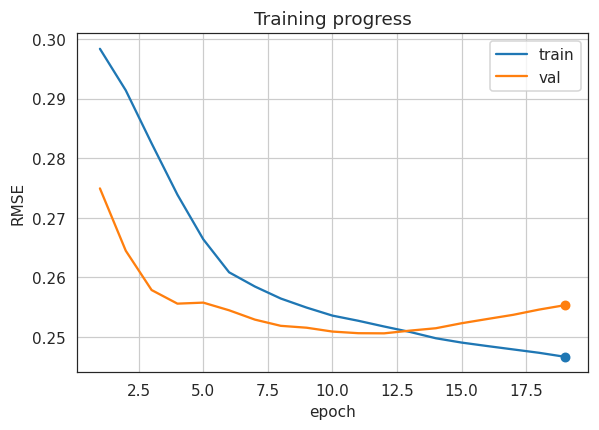

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2983 MAE=0.2298 R2=-0.0595 | Acc=0.7071 Prec=0.3402 Rec=0.0791 F1=0.1284 AUROC=0.5577
VALID→ RMSE=0.2749 MAE=0.1887 R2=0.0697 | Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7064


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2914 MAE=0.2263 R2=-0.0106 | Acc=0.7035 Prec=0.3625 Rec=0.1152 F1=0.1748 AUROC=0.5537
VALID→ RMSE=0.2645 MAE=0.1858 R2=0.1391 | Acc=0.7207 Prec=0.9565 Rec=0.0043 F1=0.0086 AUROC=0.7224


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2825 MAE=0.2186 R2=0.0502 | Acc=0.7221 Prec=0.4621 Rec=0.1171 F1=0.1868 AUROC=0.5981
VALID→ RMSE=0.2579 MAE=0.1858 R2=0.1815 | Acc=0.7378 Prec=0.7674 Rec=0.0932 F1=0.1662 AUROC=0.7311


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2739 MAE=0.2112 R2=0.1072 | Acc=0.7319 Prec=0.5232 Rec=0.1872 F1=0.2757 AUROC=0.6488
VALID→ RMSE=0.2556 MAE=0.1857 R2=0.1959 | Acc=0.7489 Prec=0.7009 Rec=0.1824 F1=0.2895 AUROC=0.7360


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2664 MAE=0.2049 R2=0.1553 | Acc=0.7425 Prec=0.5654 Rec=0.2396 F1=0.3365 AUROC=0.6841
VALID→ RMSE=0.2558 MAE=0.1840 R2=0.1949 | Acc=0.7527 Prec=0.6813 Rec=0.2220 F1=0.3348 AUROC=0.7386


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2609 MAE=0.1983 R2=0.1900 | Acc=0.7505 Prec=0.5965 Rec=0.2625 F1=0.3646 AUROC=0.7076
VALID→ RMSE=0.2545 MAE=0.1843 R2=0.2029 | Acc=0.7552 Prec=0.6542 Rec=0.2698 F1=0.3820 AUROC=0.7401


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2585 MAE=0.1973 R2=0.2048 | Acc=0.7534 Prec=0.5979 Rec=0.2914 F1=0.3919 AUROC=0.7199
VALID→ RMSE=0.2529 MAE=0.1848 R2=0.2127 | Acc=0.7564 Prec=0.6461 Rec=0.2901 F1=0.4004 AUROC=0.7414


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2565 MAE=0.1955 R2=0.2171 | Acc=0.7565 Prec=0.6071 Rec=0.3033 F1=0.4045 AUROC=0.7294
VALID→ RMSE=0.2519 MAE=0.1856 R2=0.2192 | Acc=0.7570 Prec=0.6402 Rec=0.3044 F1=0.4127 AUROC=0.7423


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2549 MAE=0.1941 R2=0.2264 | Acc=0.7584 Prec=0.6121 Rec=0.3114 F1=0.4128 AUROC=0.7358
VALID→ RMSE=0.2516 MAE=0.1857 R2=0.2211 | Acc=0.7574 Prec=0.6356 Rec=0.3165 F1=0.4225 AUROC=0.7431


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2536 MAE=0.1926 R2=0.2345 | Acc=0.7598 Prec=0.6138 Rec=0.3214 F1=0.4219 AUROC=0.7412
VALID→ RMSE=0.2509 MAE=0.1871 R2=0.2251 | Acc=0.7574 Prec=0.6288 Rec=0.3295 F1=0.4324 AUROC=0.7441


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2527 MAE=0.1919 R2=0.2397 | Acc=0.7607 Prec=0.6155 Rec=0.3255 F1=0.4258 AUROC=0.7447
VALID→ RMSE=0.2506 MAE=0.1874 R2=0.2268 | Acc=0.7572 Prec=0.6246 Rec=0.3363 F1=0.4372 AUROC=0.7444


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2518 MAE=0.1908 R2=0.2455 | Acc=0.7615 Prec=0.6161 Rec=0.3321 F1=0.4315 AUROC=0.7489
VALID→ RMSE=0.2506 MAE=0.1884 R2=0.2270 | Acc=0.7566 Prec=0.6193 Rec=0.3429 F1=0.4414 AUROC=0.7442


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2508 MAE=0.1902 R2=0.2510 | Acc=0.7626 Prec=0.6189 Rec=0.3363 F1=0.4358 AUROC=0.7520
VALID→ RMSE=0.2511 MAE=0.1885 R2=0.2242 | Acc=0.7563 Prec=0.6184 Rec=0.3417 F1=0.4402 AUROC=0.7429


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2498 MAE=0.1894 R2=0.2573 | Acc=0.7637 Prec=0.6207 Rec=0.3426 F1=0.4415 AUROC=0.7554
VALID→ RMSE=0.2515 MAE=0.1882 R2=0.2217 | Acc=0.7553 Prec=0.6135 Rec=0.3444 F1=0.4412 AUROC=0.7425


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2491 MAE=0.1888 R2=0.2616 | Acc=0.7648 Prec=0.6231 Rec=0.3473 F1=0.4461 AUROC=0.7577
VALID→ RMSE=0.2523 MAE=0.1878 R2=0.2165 | Acc=0.7545 Prec=0.6144 Rec=0.3342 F1=0.4329 AUROC=0.7409


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2485 MAE=0.1881 R2=0.2651 | Acc=0.7659 Prec=0.6270 Rec=0.3489 F1=0.4483 AUROC=0.7596
VALID→ RMSE=0.2530 MAE=0.1868 R2=0.2120 | Acc=0.7542 Prec=0.6192 Rec=0.3203 F1=0.4222 AUROC=0.7401


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2479 MAE=0.1873 R2=0.2684 | Acc=0.7667 Prec=0.6305 Rec=0.3482 F1=0.4486 AUROC=0.7612
VALID→ RMSE=0.2537 MAE=0.1866 R2=0.2077 | Acc=0.7538 Prec=0.6204 Rec=0.3148 F1=0.4177 AUROC=0.7393


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2474 MAE=0.1869 R2=0.2717 | Acc=0.7673 Prec=0.6318 Rec=0.3511 F1=0.4514 AUROC=0.7628
VALID→ RMSE=0.2546 MAE=0.1869 R2=0.2022 | Acc=0.7530 Prec=0.6190 Rec=0.3097 F1=0.4129 AUROC=0.7377


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2467 MAE=0.1863 R2=0.2757 | Acc=0.7683 Prec=0.6355 Rec=0.3522 F1=0.4532 AUROC=0.7647
VALID→ RMSE=0.2553 MAE=0.1875 R2=0.1976 | Acc=0.7516 Prec=0.6122 Rec=0.3112 F1=0.4126 AUROC=0.7363
Early stopping at epoch 19
✅ Final best model (_fin) saved: AAPL_0.25061_fin.pth
Delete variables to free memory...


[I 2025-09-25 19:02:32,521] Trial 5 finished with value: 0.2506130039691925 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.2842583767133274, 'DROPOUT_LONG': 0.33135573348879743, 'ATT_DROPOUT': 0.2098153796221877, 'CONV_K': 9, 'CONV_DILATION': 2, 'INITIAL_LR': 7.940474991899129e-05, 'ETA_MIN': 3.462218268994416e-06, 'WEIGHT_DECAY': 1.1690004421135712e-05, 'CLIPNORM': 0.9608850571285965}. Best is trial 3 with value: 0.24865210056304932.



▶ Trial 6 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.25306675845141113, 'DROPOUT_LONG': 0.3142417711484565, 'ATT_DROPOUT': 0.21420817734015965, 'CONV_K': 6, 'CONV_DILATION': 3, 'INITIAL_LR': 8.302669773701321e-05, 'ETA_MIN': 7.657354435558461e-06, 'WEIGHT_DECAY': 1.3420375920852525e-05, 'CLIPNORM': 0.5563124928630632}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


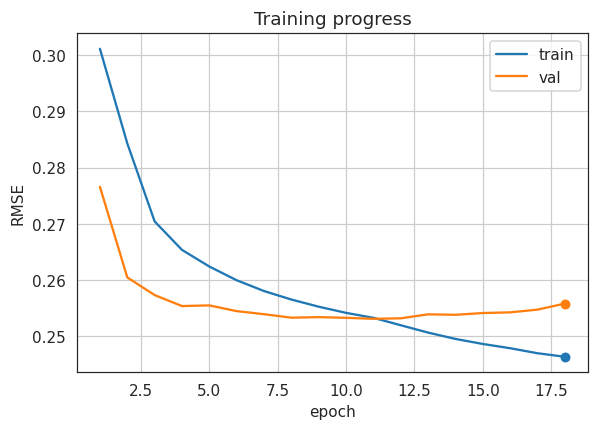

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3011 MAE=0.2316 R2=-0.0748 | Acc=0.7085 Prec=0.3636 Rec=0.0717 F1=0.1198 AUROC=0.5626
VALID→ RMSE=0.2766 MAE=0.1919 R2=0.0714 | Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6693


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2843 MAE=0.2185 R2=0.0420 | Acc=0.7133 Prec=0.4016 Rec=0.0744 F1=0.1255 AUROC=0.5607
VALID→ RMSE=0.2605 MAE=0.1867 R2=0.1765 | Acc=0.7171 Prec=0.8979 Rec=0.0174 F1=0.0342 AUROC=0.7100


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2704 MAE=0.2059 R2=0.1333 | Acc=0.7315 Prec=0.5587 Rec=0.1402 F1=0.2241 AUROC=0.6481
VALID→ RMSE=0.2573 MAE=0.1831 R2=0.1962 | Acc=0.7398 Prec=0.7550 Rec=0.1396 F1=0.2356 AUROC=0.7327


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2654 MAE=0.2027 R2=0.1654 | Acc=0.7434 Prec=0.5891 Rec=0.2395 F1=0.3405 AUROC=0.6929
VALID→ RMSE=0.2554 MAE=0.1828 R2=0.2084 | Acc=0.7493 Prec=0.7076 Rec=0.2172 F1=0.3324 AUROC=0.7393


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2624 MAE=0.2010 R2=0.1840 | Acc=0.7491 Prec=0.6039 Rec=0.2701 F1=0.3733 AUROC=0.7114
VALID→ RMSE=0.2555 MAE=0.1826 R2=0.2076 | Acc=0.7517 Prec=0.6973 Rec=0.2396 F1=0.3566 AUROC=0.7411


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2600 MAE=0.1993 R2=0.1991 | Acc=0.7516 Prec=0.6080 Rec=0.2871 F1=0.3900 AUROC=0.7206
VALID→ RMSE=0.2545 MAE=0.1828 R2=0.2140 | Acc=0.7528 Prec=0.6929 Rec=0.2505 F1=0.3679 AUROC=0.7431


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2580 MAE=0.1977 R2=0.2109 | Acc=0.7541 Prec=0.6147 Rec=0.2972 F1=0.4007 AUROC=0.7273
VALID→ RMSE=0.2539 MAE=0.1830 R2=0.2173 | Acc=0.7538 Prec=0.6902 Rec=0.2598 F1=0.3775 AUROC=0.7441


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2565 MAE=0.1961 R2=0.2201 | Acc=0.7556 Prec=0.6187 Rec=0.3037 F1=0.4074 AUROC=0.7335
VALID→ RMSE=0.2533 MAE=0.1838 R2=0.2211 | Acc=0.7545 Prec=0.6854 Rec=0.2688 F1=0.3861 AUROC=0.7441


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2552 MAE=0.1949 R2=0.2278 | Acc=0.7569 Prec=0.6204 Rec=0.3128 F1=0.4159 AUROC=0.7386
VALID→ RMSE=0.2534 MAE=0.1842 R2=0.2205 | Acc=0.7541 Prec=0.6822 Rec=0.2698 F1=0.3867 AUROC=0.7437


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2542 MAE=0.1939 R2=0.2344 | Acc=0.7584 Prec=0.6229 Rec=0.3207 F1=0.4234 AUROC=0.7429
VALID→ RMSE=0.2533 MAE=0.1850 R2=0.2213 | Acc=0.7545 Prec=0.6794 Rec=0.2753 F1=0.3918 AUROC=0.7428


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2533 MAE=0.1932 R2=0.2397 | Acc=0.7593 Prec=0.6246 Rec=0.3257 F1=0.4281 AUROC=0.7461
VALID→ RMSE=0.2531 MAE=0.1864 R2=0.2224 | Acc=0.7543 Prec=0.6778 Rec=0.2762 F1=0.3925 AUROC=0.7414


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2519 MAE=0.1919 R2=0.2477 | Acc=0.7607 Prec=0.6285 Rec=0.3298 F1=0.4326 AUROC=0.7503
VALID→ RMSE=0.2532 MAE=0.1867 R2=0.2218 | Acc=0.7545 Prec=0.6713 Rec=0.2852 F1=0.4004 AUROC=0.7410


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2506 MAE=0.1907 R2=0.2555 | Acc=0.7618 Prec=0.6308 Rec=0.3352 F1=0.4378 AUROC=0.7546
VALID→ RMSE=0.2539 MAE=0.1859 R2=0.2175 | Acc=0.7540 Prec=0.6711 Rec=0.2820 F1=0.3972 AUROC=0.7404


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2495 MAE=0.1895 R2=0.2621 | Acc=0.7631 Prec=0.6358 Rec=0.3366 F1=0.4402 AUROC=0.7579
VALID→ RMSE=0.2538 MAE=0.1868 R2=0.2180 | Acc=0.7539 Prec=0.6643 Rec=0.2897 F1=0.4035 AUROC=0.7394


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2486 MAE=0.1888 R2=0.2674 | Acc=0.7638 Prec=0.6368 Rec=0.3404 F1=0.4437 AUROC=0.7611
VALID→ RMSE=0.2541 MAE=0.1876 R2=0.2161 | Acc=0.7534 Prec=0.6587 Rec=0.2939 F1=0.4065 AUROC=0.7380


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2479 MAE=0.1881 R2=0.2719 | Acc=0.7650 Prec=0.6399 Rec=0.3446 F1=0.4479 AUROC=0.7638
VALID→ RMSE=0.2542 MAE=0.1886 R2=0.2153 | Acc=0.7530 Prec=0.6514 Rec=0.3018 F1=0.4124 AUROC=0.7371


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2470 MAE=0.1873 R2=0.2771 | Acc=0.7658 Prec=0.6410 Rec=0.3489 F1=0.4519 AUROC=0.7664
VALID→ RMSE=0.2547 MAE=0.1897 R2=0.2123 | Acc=0.7519 Prec=0.6452 Rec=0.3032 F1=0.4126 AUROC=0.7357


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2463 MAE=0.1871 R2=0.2808 | Acc=0.7667 Prec=0.6421 Rec=0.3540 F1=0.4564 AUROC=0.7682
VALID→ RMSE=0.2558 MAE=0.1879 R2=0.2056 | Acc=0.7512 Prec=0.6506 Rec=0.2896 F1=0.4008 AUROC=0.7354
Early stopping at epoch 18
✅ Final best model (_fin) saved: AAPL_0.25309_fin.pth
Delete variables to free memory...


[I 2025-09-25 19:20:38,440] Trial 6 finished with value: 0.2530921399593353 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.25306675845141113, 'DROPOUT_LONG': 0.3142417711484565, 'ATT_DROPOUT': 0.21420817734015965, 'CONV_K': 6, 'CONV_DILATION': 3, 'INITIAL_LR': 8.302669773701321e-05, 'ETA_MIN': 7.657354435558461e-06, 'WEIGHT_DECAY': 1.3420375920852525e-05, 'CLIPNORM': 0.5563124928630632}. Best is trial 3 with value: 0.24865210056304932.



▶ Trial 7 starting with:
{'look_back': 75, 'DROPOUT_SHORT': 0.2756522258892941, 'DROPOUT_LONG': 0.34003687200301425, 'ATT_DROPOUT': 0.2349705187855414, 'CONV_K': 5, 'CONV_DILATION': 2, 'INITIAL_LR': 7.413059242087625e-05, 'ETA_MIN': 1.1319208453207524e-06, 'WEIGHT_DECAY': 0.0007636236011542924, 'CLIPNORM': 0.6787158921604384}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


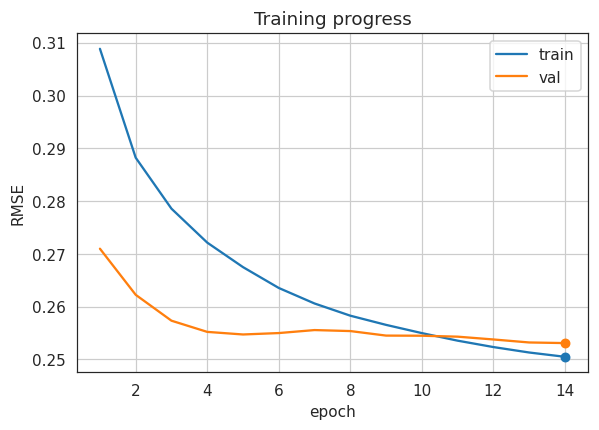

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3089 MAE=0.2386 R2=-0.1326 | Acc=0.7071 Prec=0.3866 Rec=0.1142 F1=0.1763 AUROC=0.5795
VALID→ RMSE=0.2710 MAE=0.1870 R2=0.1044 | Acc=0.7180 Prec=0.8757 Rec=0.0090 F1=0.0178 AUROC=0.6892


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2882 MAE=0.2222 R2=0.0136 | Acc=0.7119 Prec=0.4086 Rec=0.1106 F1=0.1741 AUROC=0.5674
VALID→ RMSE=0.2623 MAE=0.1845 R2=0.1612 | Acc=0.7269 Prec=0.8476 Rec=0.0476 F1=0.0901 AUROC=0.7287


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2786 MAE=0.2144 R2=0.0786 | Acc=0.7267 Prec=0.5086 Rec=0.1282 F1=0.2048 AUROC=0.6096
VALID→ RMSE=0.2573 MAE=0.1837 R2=0.1923 | Acc=0.7415 Prec=0.7573 Rec=0.1330 F1=0.2262 AUROC=0.7427


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2721 MAE=0.2092 R2=0.1207 | Acc=0.7344 Prec=0.5442 Rec=0.1998 F1=0.2923 AUROC=0.6544
VALID→ RMSE=0.2552 MAE=0.1842 R2=0.2056 | Acc=0.7475 Prec=0.7241 Rec=0.1801 F1=0.2884 AUROC=0.7479


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2675 MAE=0.2052 R2=0.1504 | Acc=0.7408 Prec=0.5665 Rec=0.2379 F1=0.3351 AUROC=0.6810
VALID→ RMSE=0.2547 MAE=0.1848 R2=0.2086 | Acc=0.7490 Prec=0.7048 Rec=0.2007 F1=0.3124 AUROC=0.7491


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2635 MAE=0.2018 R2=0.1753 | Acc=0.7465 Prec=0.5875 Rec=0.2567 F1=0.3572 AUROC=0.6994
VALID→ RMSE=0.2550 MAE=0.1848 R2=0.2070 | Acc=0.7493 Prec=0.6961 Rec=0.2090 F1=0.3215 AUROC=0.7481


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2606 MAE=0.1995 R2=0.1936 | Acc=0.7501 Prec=0.5987 Rec=0.2725 F1=0.3745 AUROC=0.7130
VALID→ RMSE=0.2556 MAE=0.1843 R2=0.2034 | Acc=0.7489 Prec=0.6950 Rec=0.2075 F1=0.3196 AUROC=0.7467


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2583 MAE=0.1972 R2=0.2078 | Acc=0.7532 Prec=0.6091 Rec=0.2821 F1=0.3857 AUROC=0.7223
VALID→ RMSE=0.2554 MAE=0.1843 R2=0.2046 | Acc=0.7498 Prec=0.6872 Rec=0.2191 F1=0.3323 AUROC=0.7450


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2566 MAE=0.1955 R2=0.2185 | Acc=0.7552 Prec=0.6131 Rec=0.2939 F1=0.3973 AUROC=0.7300
VALID→ RMSE=0.2545 MAE=0.1848 R2=0.2099 | Acc=0.7508 Prec=0.6805 Rec=0.2316 F1=0.3456 AUROC=0.7438


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2550 MAE=0.1943 R2=0.2280 | Acc=0.7568 Prec=0.6148 Rec=0.3051 F1=0.4079 AUROC=0.7366
VALID→ RMSE=0.2545 MAE=0.1851 R2=0.2101 | Acc=0.7513 Prec=0.6757 Rec=0.2400 F1=0.3542 AUROC=0.7422


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2536 MAE=0.1932 R2=0.2366 | Acc=0.7586 Prec=0.6197 Rec=0.3128 F1=0.4157 AUROC=0.7418
VALID→ RMSE=0.2543 MAE=0.1853 R2=0.2112 | Acc=0.7516 Prec=0.6700 Rec=0.2483 F1=0.3623 AUROC=0.7412


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2524 MAE=0.1922 R2=0.2439 | Acc=0.7599 Prec=0.6215 Rec=0.3204 F1=0.4228 AUROC=0.7457
VALID→ RMSE=0.2538 MAE=0.1854 R2=0.2145 | Acc=0.7524 Prec=0.6678 Rec=0.2564 F1=0.3705 AUROC=0.7414


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2513 MAE=0.1913 R2=0.2500 | Acc=0.7612 Prec=0.6234 Rec=0.3286 F1=0.4304 AUROC=0.7496
VALID→ RMSE=0.2532 MAE=0.1862 R2=0.2180 | Acc=0.7527 Prec=0.6623 Rec=0.2645 F1=0.3780 AUROC=0.7412


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2505 MAE=0.1905 R2=0.2549 | Acc=0.7624 Prec=0.6272 Rec=0.3313 F1=0.4335 AUROC=0.7524
VALID→ RMSE=0.2531 MAE=0.1867 R2=0.2187 | Acc=0.7526 Prec=0.6587 Rec=0.2683 F1=0.3813 AUROC=0.7409


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# importlib.reload(dual_lstm) ########################

# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
